## CNN for image Classification

### importing libraries

In [1]:
# importing libraries for CNN

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
# checking for GPU

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


### Creating and organizing the images into train, validation and test 
- download only the train data from kaggle
- https://www.kaggle.com/c/dogs-vs-cats/data
- make a new directory called dogs-vs-cats and extract all the images in this directory
- change your directory to the dogs-vs-cats as shown below

In [6]:
# creating and organizing the data

dir = r"C:\Users\tejas\Desktop\work\Portfolio_projects\tensorflow\data\dogs-vs-cats"

os.chdir(dir)

# creating directories for dogs and cat images
if os.path.isdir('train\dog') is False:
    os.makedirs('train\dog')
    os.makedirs('train\cat')
    os.makedirs('valid\dog')
    os.makedirs('valid\cat')
    os.makedirs('test\dog')
    os.makedirs('test\cat')
    
    # iterating through the data to move the cat and dog images to respective directories
    # since we have 25000 images we just take a sample of them here
    for c in random.sample(glob.glob('cat*'), 500):
        shutil.move(c, 'train\cat')
    for c in random.sample(glob.glob('dog*'), 500):
        shutil.move(c, 'train\dog')
    for c in random.sample(glob.glob('cat*'), 100):
        shutil.move(c, 'valid\cat')
    for c in random.sample(glob.glob('dog*'), 100):
        shutil.move(c, 'valid\dog')
    for c in random.sample(glob.glob('cat*'), 50):
        shutil.move(c, 'test\cat')
    for c in random.sample(glob.glob('dog*'), 50):
        shutil.move(c, 'test\dog')
    

In [8]:
# Assigning train, valid and test respectively
# since we are already in the current directory we don't have to givethe complete path

train_path = 'train'
valid_path = 'valid'
test_path = 'test'

In [9]:
# using ImageDataGenerator and flow from directory
# By using ImageDataGenerator we can apply any random transformations on each training image as it is passed to the model one by one.
# The flow_from_directory() method takes a path of a directory and generates batches of augmented data. 
# The directory structure is very important when you are using flow_from_directory() method. 
# The flow_from_directory() assumes: The root directory contains at least two folders one for train and one for the test.

# preprocessing_function is leveraging pre trained weights
# target_size resizes all the images to the specified size
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)

# Here shuffle=False because, later we have to compare the prediction of the image classes to their actual classes
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)


Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [11]:
# the above code creates a generator function and 
train_batches

In [10]:
# calling the iterator function next to pass the data one after another
# since our batch size is 10, 10 number of data is passed one after another as shown below

imgs, labels = next(train_batches)

In [14]:
imgs.shape

(10, 224, 224, 3)

In [15]:
labels.shape

(10, 2)

### Plotting the train sample images

In [20]:
# creating a function to plot the images
# since batch size is 10 plotting 10 images

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

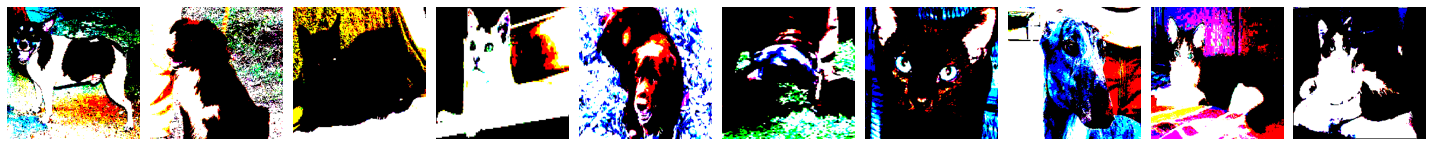

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [21]:
# calling the function
# it can be observed that the image color is distorted this is because of the preprocessed weights of vgg16
# here [0. 1.] represents a dog and [1. 0.] represents a cat

plotImages(imgs)
print(labels)

### Building and Training a CNN model

In [30]:
# building a CNN sequential model
# padding=same does not reduce the image dimension after convolution

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 200704)            0         
                                                                 
 dense_2 (Dense)             (None, 2)                

In [33]:
# compiling the model for backpropogation
# categorical_crossentropy is used when there are more that 2 classes to predict, however it can be used for 2 classes also

model.compile(optimizer= Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [35]:
# fitting the model with validation data
# The train_batches has both the images and labels as a generator, hence we just need to pass x= train_batches 

model.fit(x= train_batches, validation_data= valid_batches, epochs = 10, verbose = 2)

Epoch 1/10
100/100 - 71s - loss: 15.9112 - accuracy: 0.5900 - val_loss: 4.1577 - val_accuracy: 0.5850 - 71s/epoch - 715ms/step
Epoch 2/10
100/100 - 55s - loss: 2.0310 - accuracy: 0.7580 - val_loss: 2.5093 - val_accuracy: 0.6150 - 55s/epoch - 553ms/step
Epoch 3/10
100/100 - 59s - loss: 0.5761 - accuracy: 0.8800 - val_loss: 2.6220 - val_accuracy: 0.6350 - 59s/epoch - 589ms/step
Epoch 4/10
100/100 - 65s - loss: 0.1804 - accuracy: 0.9490 - val_loss: 2.7146 - val_accuracy: 0.6400 - 65s/epoch - 645ms/step
Epoch 5/10
100/100 - 68s - loss: 0.0503 - accuracy: 0.9830 - val_loss: 3.1372 - val_accuracy: 0.6500 - 68s/epoch - 677ms/step
Epoch 6/10
100/100 - 65s - loss: 0.0446 - accuracy: 0.9830 - val_loss: 2.2216 - val_accuracy: 0.6550 - 65s/epoch - 654ms/step
Epoch 7/10
100/100 - 66s - loss: 0.0059 - accuracy: 0.9990 - val_loss: 2.0615 - val_accuracy: 0.6900 - 66s/epoch - 655ms/step
Epoch 8/10
100/100 - 66s - loss: 6.9752e-04 - accuracy: 1.0000 - val_loss: 2.1359 - val_accuracy: 0.6900 - 66s/epoch 

### Prediction / Inference

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

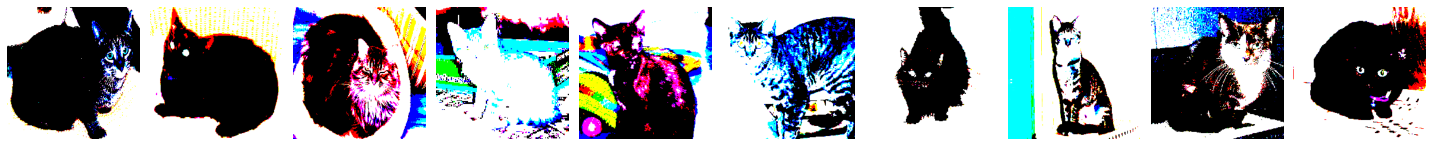

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [36]:
# plotting the test images
# calling the function which we created before to plot the images

test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [37]:
# These are the classes of the test batches
# 0 is for cat and 1 is for dog
# since we haven't shuffled the test data we have all cats on the top

test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [38]:
# predicting the output from the test batch data

predictions = model.predict(x= test_batches, verbose=0)

In [40]:
# [1., 0.] represents that index 0 has 1 that has the highest probability hence the class is cat, since cat has the label 0
# [0., 1.] this says dog has the highest probability, since its label is 1

np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [42]:
# creating a confusion matrix
# test_batches.classes to get the class labels
# np.argmax(predictions, axis= -1) to get the index of the most probable class

cm = confusion_matrix(y_true = test_batches.classes, y_pred= np.argmax(predictions, axis= -1))

In [45]:
# to know which index is cat and dog

test_batches.class_indices

{'cat': 0, 'dog': 1}

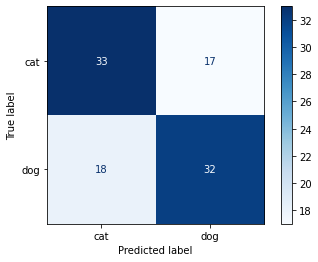

In [43]:
# code to plot the confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cat', 'dog'])

disp.plot(cmap=plt.cm.Blues)
plt.show()

### We can see that the model is completely overfitting on training data hence the training accuracy is high and the testing accuracy is very low

## Building Fine Tuned model using VGG16, a preprocessing technique
- Every image has RGB color scheme
- VGG16 subtracted the mean pixel of red with the red colors in the image, similarly with green and blue.
- This is the reason the image looks distorted when the preprocessing_function=tf.keras.applications.vgg16.preprocess_input is called
- Since the training data was preprocessed while training, the new data for testing also should be preprocessed and this can be acheived easily through VGG16

In [46]:
# download the model from keras applications

vgg16_model = tf.keras.applications.vgg16.VGG16()

553476096/553467096 [==============================] - 253s 0us/step


In [47]:
# summary of the VGG16 model
# note that VGG16 has 1000 prebuilt prediction classes
# for our use case we just have 2 classes to predict hence we would be changing that

vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [48]:
# The imported Model's type is Functional
# since we are working with sequential model right now, we need to convert it to sequential

type(vgg16_model)

keras.engine.functional.Functional

In [49]:
# initializing Sequential class to the object model
model = Sequential()

# iterating through all the layers except the last layer (because we need to change it to 2 class prediction layer)
# every layer is added into the Sequential model
# it can be seen that all the layers are added except the last layer
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    print(layer)

In [51]:
# They are exactly the same with the inbuild vgg16 model except this model does not have the last layer
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [52]:
# now we need to set layer.trainable=false because VGG16 has already been trained on the features of cats and dogs
# We don't have to retrain the model again
# We are freezing the weights here

for layer in model.layers:
    layer.trainable = False

In [53]:
# adding the output layer

model.add(Dense(units=2, activation= 'softmax'))

In [54]:
# we can observe that the last output layer is 2
# Also the total trainable parameters are only 8194 because we freezed the trainable parameters before
# All the 8194 trainable parameters are only from the last output layer we added

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

## Training the fine tuned VGG16 model

In [56]:
# compiling the model withe the optimizer, loss and metrics

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
# fitting the model with the training and validation batches
# because of the pre trained network, we get an amazing accuracy

model.fit(x= train_batches, validation_data= valid_batches, epochs = 5, verbose= 2)

Epoch 1/5
100/100 - 400s - loss: 0.3298 - accuracy: 0.8680 - val_loss: 0.0962 - val_accuracy: 0.9550 - 400s/epoch - 4s/step
Epoch 2/5
100/100 - 361s - loss: 0.1089 - accuracy: 0.9630 - val_loss: 0.0561 - val_accuracy: 0.9900 - 361s/epoch - 4s/step
Epoch 3/5
100/100 - 362s - loss: 0.0726 - accuracy: 0.9810 - val_loss: 0.0481 - val_accuracy: 0.9750 - 362s/epoch - 4s/step
Epoch 4/5
100/100 - 361s - loss: 0.0521 - accuracy: 0.9860 - val_loss: 0.0389 - val_accuracy: 0.9950 - 361s/epoch - 4s/step
Epoch 5/5
100/100 - 376s - loss: 0.0389 - accuracy: 0.9870 - val_loss: 0.0382 - val_accuracy: 0.9900 - 376s/epoch - 4s/step


## Prediction / Inference

In [58]:
#getting the test_batch for prediction

predictions = model.predict(x= test_batches, verbose= 0)

In [59]:
# getting the classes of the test set
# note that we are not shuffling the test set so that we can compare with the predictions classes

test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [60]:
# calling the confusion matrix function

cm = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions, axis = -1))

In [62]:
# checking which index is 0 and 1

test_batches.class_indices

{'cat': 0, 'dog': 1}

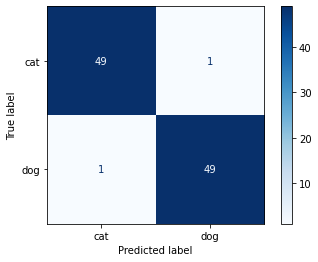

In [64]:
# plotting the confusion matrix

cm_plot_labels = ['cat', 'dog']

disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= cm_plot_labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [65]:
print(49/50)

0.98


### We can see that there is a very high accuracy and the model correctly predicted both the classes with an accuracy of 98%

## Training custom untrained data by any pre-trained model

### MobileNet
- Light weight in size
- Great for mobile devices
- Size of VGG16 is 553MB where as MobileNet size is only 17MB
- MobileNet has 4.2 Million parameters
- MobileNet is not as accurate as VGG16, however only a small accuracy is the difference in tradeoff


In [66]:
# importing libraries

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
# checking for GPU

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


In [68]:
# downloading the mobileNet pre-trained model
# mobilenet was trained on imagenet libraries

mobile = tf.keras.applications.mobilenet.MobileNet()

17235968/17225924 [==============================] - 7s 0us/step


In [71]:
# function to process the input image

img_path = r'C:\Users\tejas\Desktop\work\Portfolio_projects\tensorflow\data\MobileNet-samples'

def prepare_image(file):
    
    img = image.load_img(img_path + file, target_size=(224, 224)) # loading the image throug keras API load_img
    img_array = image.img_to_array(img) # converting the image to an array
    img_array_expanded_dims = np.expand_dims(img_array, axis=0) # expanding the dimension of the image array as expected by MobileNet
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims) # preprocessing the image to reduce the scale between -1 and 1

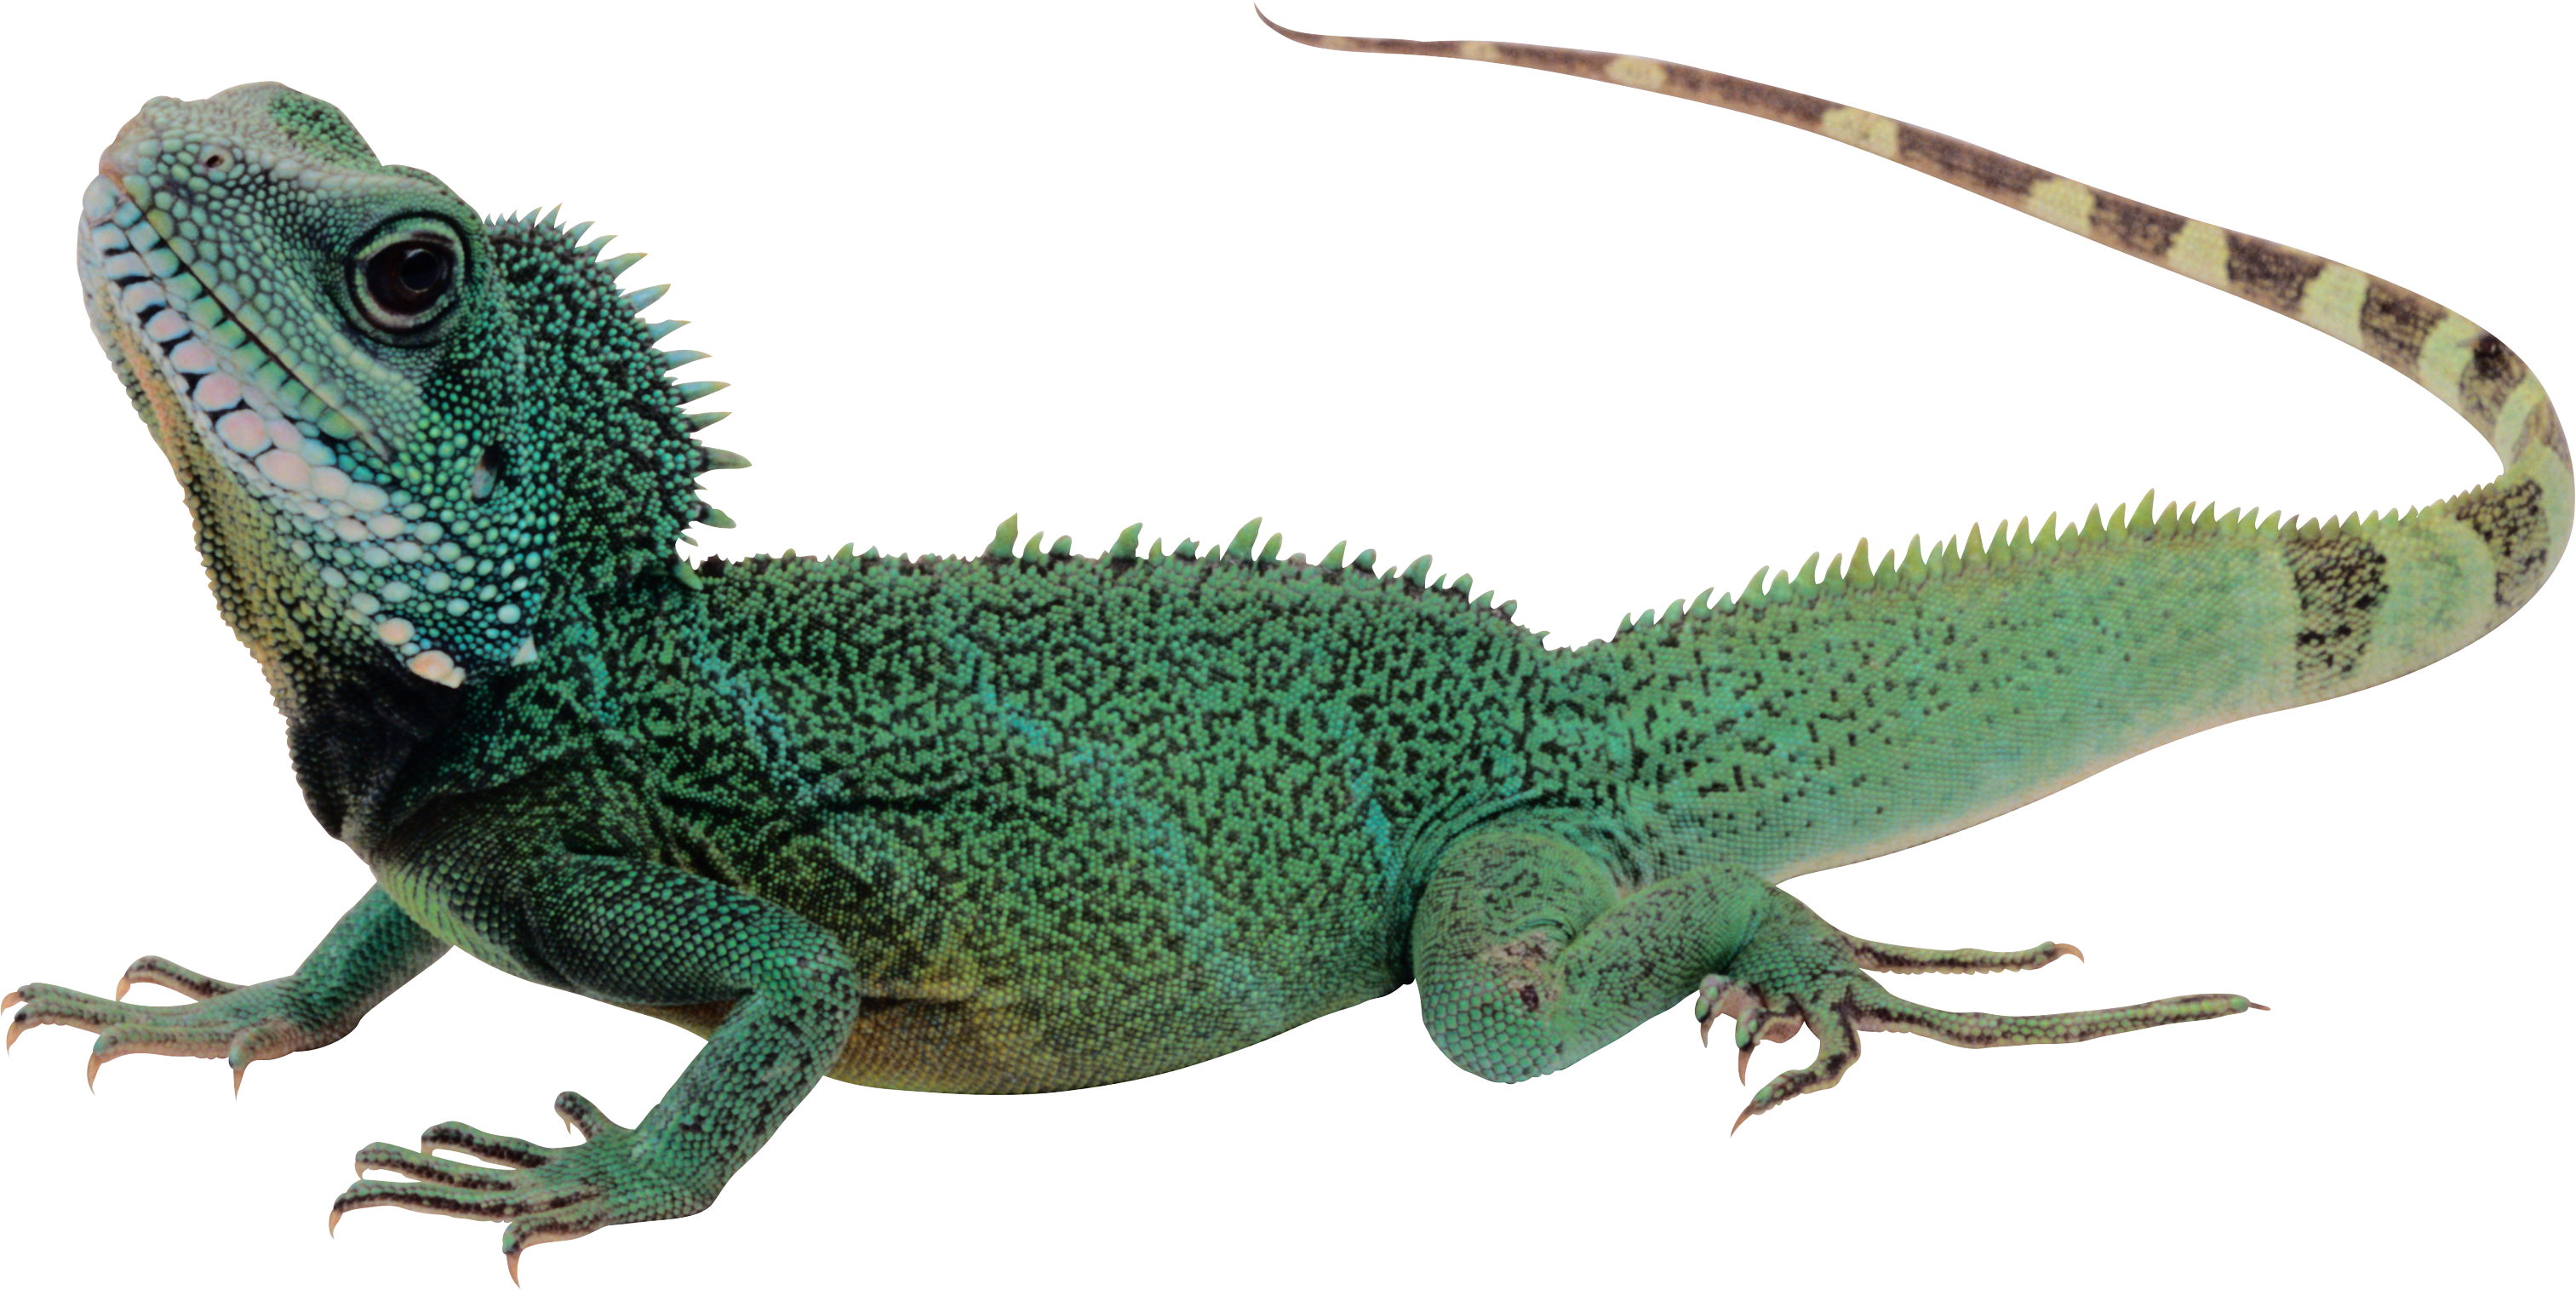

In [73]:
# passing a random image to check

from IPython.display import Image

Image(filename= img_path + '\\1.PNG', width=300,height=200) 

In [94]:
os.chdir("../data")
print(os.getcwd())

C:\Users\tejas\Desktop\work\Portfolio_projects\tensorflow\data


In [92]:
# passing the same image to the above preprocessing function 

# preprocessing the image
preprocessed_image = prepare_image('\\1.PNG')

# predicting the preprocessed image with mobilenet model
predictions = mobile.predict(preprocessed_image)

# calling decode_predictions keras API function to give the top 5 predictions out of the 1000 imagenet classes
results = imagenet_utils.decode_predictions(predictions)
results

49152/35363 [=========================================] - 0s 1us/step


[[('n01682714', 'American_chameleon', 0.57064366),
  ('n01694178', 'African_chameleon', 0.19318135),
  ('n01677366', 'common_iguana', 0.10827039),
  ('n01693334', 'green_lizard', 0.077062614),
  ('n01687978', 'agama', 0.023457762)]]

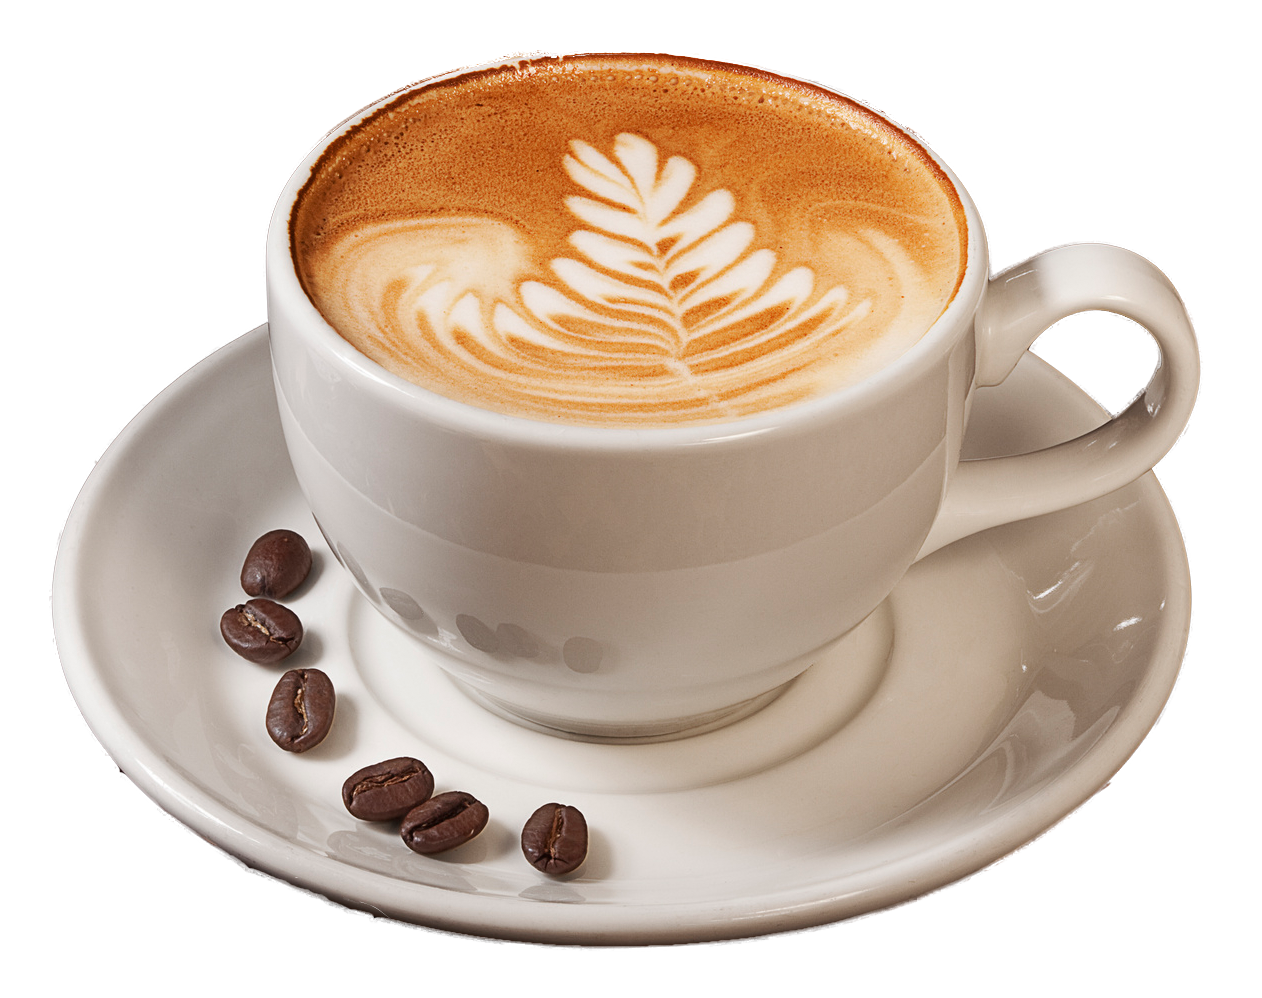

In [97]:
# moving on to a second image

Image(filename=img_path + '\\2.PNG', width=300,height=200)

In [99]:
# passing the same image to the above preprocessing function 
# using all the preprocessing steps same as above image

preprocessed_image = prepare_image('\\2.PNG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n07920052', 'espresso', 0.98888385),
  ('n07930864', 'cup', 0.00958599),
  ('n07932039', 'eggnog', 0.0007359698),
  ('n03063599', 'coffee_mug', 0.0006169288),
  ('n03063689', 'coffeepot', 3.1316125e-05)]]

## Custom dataset (Unseen by imageNet library)

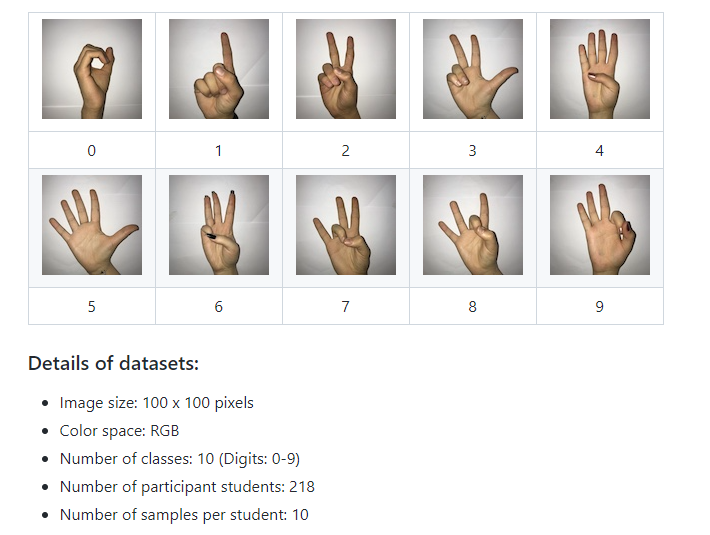